In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import json
from pprint import pprint
import collections

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import ipywidgets as widgets
from matplotlib import gridspec
from scipy.stats import gaussian_kde
from tqdm import tqdm

project_root = '..'
sys.path.append(project_root)

from sleeprnn.data.loader import load_dataset, RefactorUnpickler
from sleeprnn.data import utils, stamp_correction
from sleeprnn.detection.feeder_dataset import FeederDataset
from sleeprnn.detection import metrics
from sleeprnn.detection.postprocessor import PostProcessor
from sleeprnn.common import constants, pkeys

SEED_LIST = [123, 234, 345, 456]
RESULTS_PATH = os.path.join(project_root, 'results')
COMPARISON_PATH = os.path.join(project_root, 'resources', 'comparison_data')
DPI = 200
CUSTOM_COLOR = {'red': '#c62828', 'grey': '#455a64', 'blue': '#0277bd', 'green': '#43a047'} 

%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
prefix = '20190618_grid_fb_cwtrect_%s_train_%s'
optimal_thr_dict = {}
optimal_thr_dict['mass_ss'] = {
0.25: [0.4, 0.56, 0.38, 0.46],
0.50: [0.48, 0.6, 0.32, 0.46],
0.75: [0.42, 0.38, 0.36, 0.48],
1.00: [0.58, 0.5, 0.54, 0.5],
1.25: [0.42, 0.38, 0.48, 0.48],
1.50: [0.4, 0.36, 0.54, 0.52],
1.75: [0.42, 0.38, 0.54, 0.46],
2.00: [0.44, 0.5, 0.44, 0.44], 
}
optimal_thr_dict['mass_kc'] = {
0.25: [0.4, 0.54, 0.48, 0.5],
0.50: [0.48, 0.58, 0.54, 0.46],
0.75: [0.5, 0.46, 0.56, 0.52],
1.00: [0.52, 0.42, 0.52, 0.4],
1.25: [0.34, 0.48, 0.5, 0.48],
1.50: [0.28, 0.44, 0.54, 0.46],
1.75: [0.38, 0.46, 0.52, 0.44],
2.00: [0.32, 0.38, 0.52, 0.4], 
}

In [3]:
task_mode = constants.N2_RECORD
dataset_name = constants.MASS_SS_NAME
which_expert = 1
ckpt_folder_prefix = prefix % (task_mode, dataset_name)
fb_values = np.sort(np.asarray(list(optimal_thr_dict[dataset_name].keys())))

params_file = os.path.join(RESULTS_PATH, ckpt_folder_prefix, 'fb_%s' % fb_values[0], 'seed0', 'params.json')
with open(params_file, 'r') as handle:
    params = json.load(handle)
dataset = load_dataset(dataset_name, load_checkpoint=True, params=params)

# Read predictions
print('Loading predictions')
predictions = {}
for single_fb in fb_values:
    predictions[single_fb] = []
    for k, seed in enumerate(SEED_LIST):
        filepath = os.path.join(
            RESULTS_PATH, 'predictions_%s' % dataset_name, 
            ckpt_folder_prefix, 'fb_%s' % single_fb, 'seed%d' % k, 
            'prediction_%s_val.pkl' % task_mode)
        with open(filepath, 'rb') as handle:
            this_pred = RefactorUnpickler(handle).load()
        predictions[single_fb].append(this_pred)

print('Done', flush=True)

Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_ss with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482037
Loading predictions
Done


In [4]:
iou_list = [0.1 * i for i in range(1, 10)]
print('Measuring performance', flush=True)
af1_dict = {}
f1vsiou_dict = {}
for single_fb in fb_values:
    print('Processing fb %s' % single_fb, flush=True)
    af1_dict[single_fb] = []
    f1vsiou_dict[single_fb] = []
    for k, seed in enumerate(SEED_LIST):
        _, val_ids = utils.split_ids_list(dataset.train_ids, seed=seed, verbose=False)
        data_inf = FeederDataset(dataset, val_ids, task_mode=task_mode, which_expert=which_expert)
        pred = predictions[single_fb][k]
        pred.set_probability_threshold(optimal_thr_dict[dataset_name][single_fb][k])
        
        this_events = data_inf.get_stamps()
        this_detections = pred.get_stamps()
        
        af1 = metrics.average_metric_with_list(
            this_events, this_detections, verbose=False)
        f1vsiou = metrics.metric_vs_iou_with_list(
            this_events, this_detections, iou_list, verbose=False)
        
        af1_dict[single_fb].append(af1)
        f1vsiou_dict[single_fb].append(f1vsiou)
print('Done')

Measuring performance
Processing fb 0.25
Processing fb 0.5
Processing fb 0.75
Processing fb 1.0
Processing fb 1.25
Processing fb 1.5
Processing fb 1.75
Processing fb 2.0
Done


In [5]:
# Check
for single_fb in fb_values:
    print('fb %1.2f, VAL AF1 %1.4f +- %1.4f' % (single_fb, np.mean(af1_dict[single_fb]), np.std(af1_dict[single_fb])))

fb 0.25, VAL AF1 0.6857 +- 0.0214
fb 0.50, VAL AF1 0.6874 +- 0.0167
fb 0.75, VAL AF1 0.6821 +- 0.0160
fb 1.00, VAL AF1 0.6871 +- 0.0133
fb 1.25, VAL AF1 0.6831 +- 0.0158
fb 1.50, VAL AF1 0.6825 +- 0.0188
fb 1.75, VAL AF1 0.6815 +- 0.0122
fb 2.00, VAL AF1 0.6786 +- 0.0169


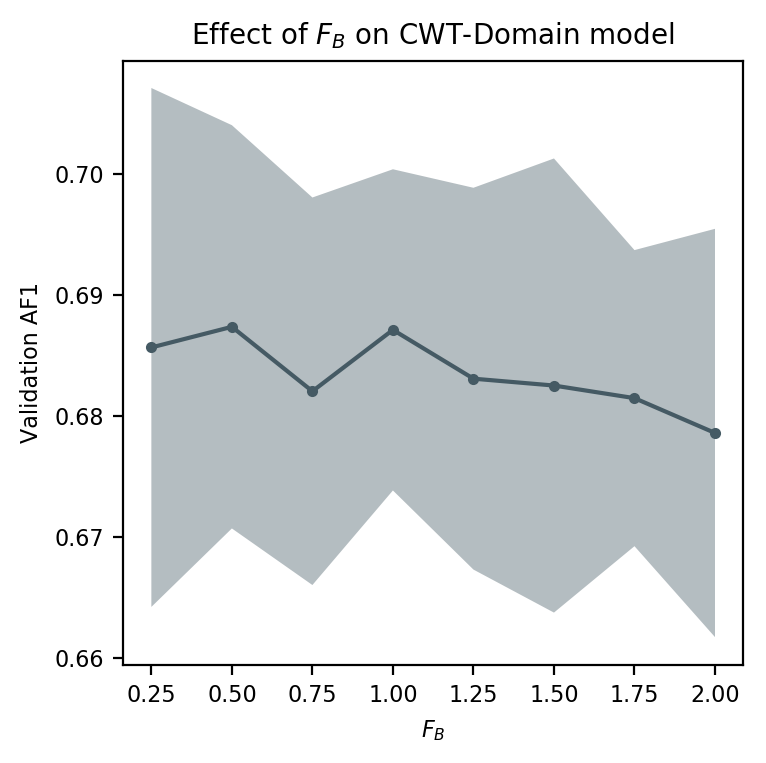

In [8]:
# AF1
title_fontsize = 10
other_fontsize = 8

fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=DPI)

af1_mean_values = np.asarray([np.mean(af1_dict[single_fb]) for single_fb in fb_values])
af1_std_values = np.asarray([np.std(af1_dict[single_fb]) for single_fb in fb_values])

ax.plot(fb_values, af1_mean_values, color=CUSTOM_COLOR['grey'], marker='.')
ax.fill_between(fb_values, af1_mean_values - af1_std_values, af1_mean_values + af1_std_values, facecolor=CUSTOM_COLOR['grey'], alpha=0.4)
ax.tick_params(labelsize=other_fontsize)
ax.set_title('Effect of $F_B$ on CWT-Domain model', fontsize=title_fontsize)
ax.set_ylabel('Validation AF1', fontsize=other_fontsize)
ax.set_xlabel('$F_B$', fontsize=other_fontsize)
plt.show()

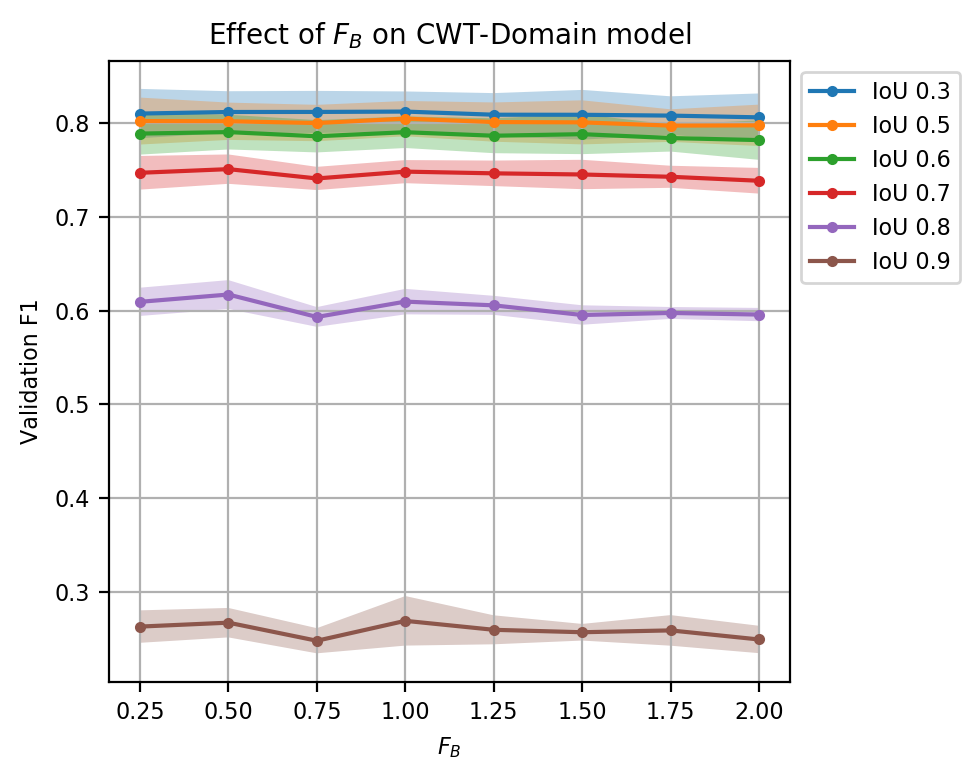

In [39]:
# F1 values
iou_show_list = [0.3, 0.5, 0.6, 0.7, 0.8, 0.9]

# title_fontsize = 8
# other_fontsize = 6
# fig, ax = plt.subplots(1, 4, figsize=(12, 3), dpi=DPI, sharey=True)
# for i, iou_show in enumerate(iou_show_list):
#     f1_idx = np.where(np.isclose(iou_list, iou_show))[0][0]
#     f1_mean_values = []
#     f1_std_values = []
#     for single_fb in fb_values:
#         f1_values = [f1vsiou_dict[single_fb][k][f1_idx] for k in range(len(SEED_LIST))]
#         f1_mean_values.append(np.mean(f1_values))
#         f1_std_values.append(np.std(f1_values))
#     f1_mean_values = np.asarray(f1_mean_values)
#     f1_std_values = np.asarray(f1_std_values)
#     ax[i].plot(fb_values, f1_mean_values, color=CUSTOM_COLOR['grey'], marker='.')
#     ax[i].fill_between(fb_values, f1_mean_values - f1_std_values, f1_mean_values + f1_std_values, facecolor=CUSTOM_COLOR['grey'], alpha=0.4)
#     ax[i].tick_params(labelsize=other_fontsize)
#     ax[i].set_title('Effect of $F_B$ on CWT-Domain model', fontsize=title_fontsize)
#     ax[i].set_ylabel('Validation F1 at IoU %1.1f' % iou_show, fontsize=other_fontsize)
#     ax[i].set_xlabel('$F_B$', fontsize=other_fontsize)
#     ax[i].grid()
# plt.tight_layout()    
# plt.show()

title_fontsize = 10
other_fontsize = 8
alpha = 0.3
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=200)
for i, iou_show in enumerate(iou_show_list):
    f1_idx = np.where(np.isclose(iou_list, iou_show))[0][0]
    f1_mean_values = []
    f1_std_values = []
    for single_fb in fb_values:
        f1_values = [f1vsiou_dict[single_fb][k][f1_idx] for k in range(len(SEED_LIST))]
        f1_mean_values.append(np.mean(f1_values))
        f1_std_values.append(np.std(f1_values))
    f1_mean_values = np.asarray(f1_mean_values)
    f1_std_values = np.asarray(f1_std_values)
    line, = ax.plot(fb_values, f1_mean_values, marker='.', label='IoU %1.1f' % iou_show)
    ax.fill_between(fb_values, f1_mean_values - f1_std_values, f1_mean_values + f1_std_values, facecolor=line.get_color(), alpha=alpha)
ax.tick_params(labelsize=other_fontsize)
ax.set_title('Effect of $F_B$ on CWT-Domain model', fontsize=title_fontsize)
ax.set_ylabel('Validation F1', fontsize=other_fontsize)
ax.set_xlabel('$F_B$', fontsize=other_fontsize)
ax.grid()
ax.legend(bbox_to_anchor=(1.0, 1.0), fontsize=other_fontsize)
plt.tight_layout()    
plt.show()

2